# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto

1. Descarga los datos y haz el remuestreo por una hora.

2. Analiza los datos.

3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.

4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de datos

Los datos se almacenan en el archivo /datasets/taxi.csv.  Descarga el conjunto de datos

- El número de pedidos está en la columna num_orders.

## Evaluación del proyecto

Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

- ¿Seguiste todos los pasos de las instrucciones?
- ¿Cómo preparaste los datos?
- ¿Qué modelos e hiperparámetros consideraste?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles fueron tus hallazgos?
- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste el código limpio?
- Ya tienes tus hojas informativas y los resúmenes de los capítulos, por lo que todo está listo para continuar con el proyecto.

# Importar librerías

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats as st
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from IPython.display import display
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb
import joblib

# Importamos el archivo

In [31]:
data=pd.read_csv('datasets/taxi.csv')
data['datetime']=pd.to_datetime(data['datetime'])
data.set_index('datetime',inplace=True)
data.sort_index(inplace=True)
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


# Preparación de datos

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [33]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Ausentes

In [34]:
print('Ausentes:',data.isna().sum())

Ausentes: num_orders    0
dtype: int64


In [35]:
print('Ausentes:',data.index.isna().sum())

Ausentes: 0


## Duplicados

In [36]:
print('Duplicados:',data.index.duplicated().sum())

Duplicados: 0


# Remuestreo

In [37]:
data=data.resample('1H').sum()
data_model=data.copy()


In [38]:
data['rolling_mean']=data.rolling(12).mean()

# Análisis

In [39]:
data_analysis=data.copy()

<Axes: xlabel='datetime'>

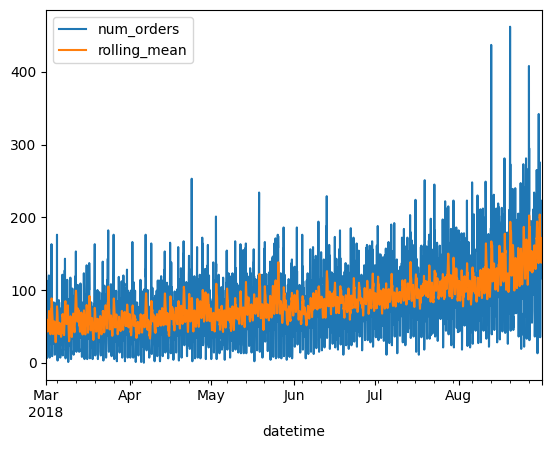

In [40]:
data_analysis.plot()

<Axes: xlabel='month'>

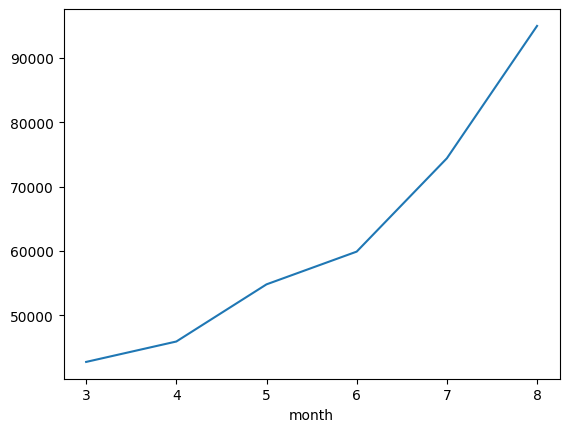

In [41]:
data_analysis['month']=data_analysis.index.month
data_1=data_analysis.groupby('month')['num_orders'].sum()
data_1.plot()

Podemos ver que el número de pedido de taxis aumenta a lo largo del año teniendo una subida para el més de agosto.

<Axes: xlabel='hour'>

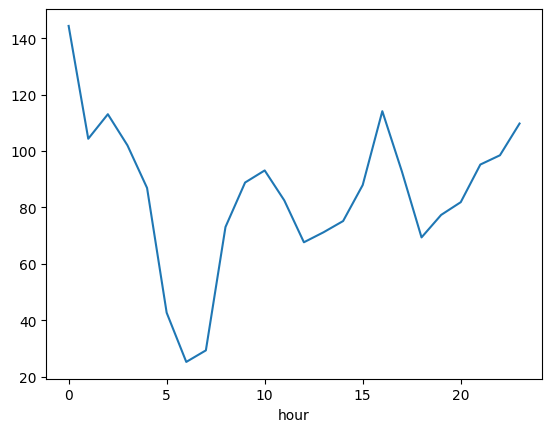

In [42]:
data_analysis['hour']=data_analysis.index.hour
data_2=data_analysis.groupby('hour')['num_orders'].mean()
data_2.plot()

Podemos ver que los pedidos de servicio inician con un valor aproximado de 140 pedidos a las 0, depues cae el número de servicios y vuelve a aumentar para las 10, posteriormente vuelve a aumentar a las 15 y a las 24.

## Tendencias y estacionalidad

In [43]:
data_seasonal=data_analysis['num_orders']
data_seasonal.head()

datetime
2018-03-01 00:00:00    124
2018-03-01 01:00:00     85
2018-03-01 02:00:00     71
2018-03-01 03:00:00     66
2018-03-01 04:00:00     43
Freq: H, Name: num_orders, dtype: int64

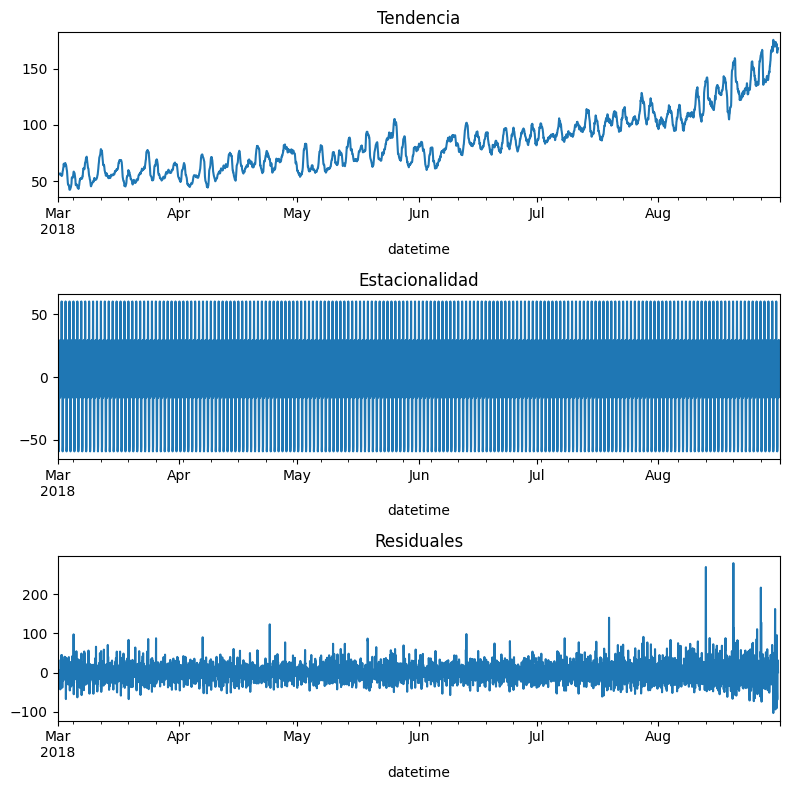

In [44]:
descomposed = seasonal_decompose(data_seasonal)

plt.figure(figsize=(8, 8))

plt.subplot(311)
descomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
descomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
descomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

plt.tight_layout()

Podemos ver que la tendencia es el aumento de los serviciós hacia el final del año. No es posible ver con claridad la estacionalidad, la veremos más a detalle posteriormente. El residuo es ruido, no representa nada relevante.


# Análisis de la estacionalidad para los primeros 8 días de agosto.

<Axes: xlabel='datetime'>

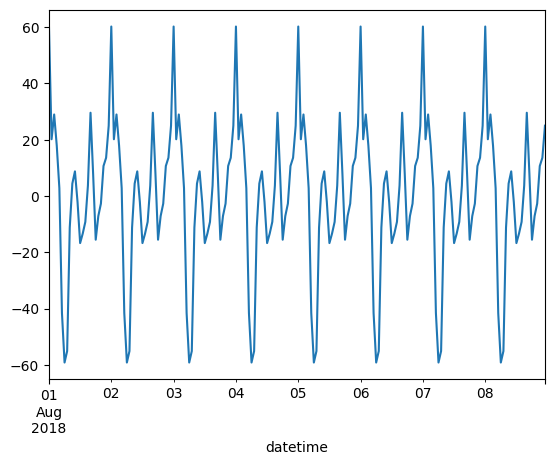

In [45]:
descomposed.seasonal['2018-08-01':'2018-08-08'].plot()


Podemos ver que los servicios tienen la misma distribución cada día, se repite el análisis que hicimos de los picos que tienen los servicios a distintas horas como hora **0, 10, 15 y 24**.

# Diferencias de series temporales

<Axes: xlabel='datetime'>

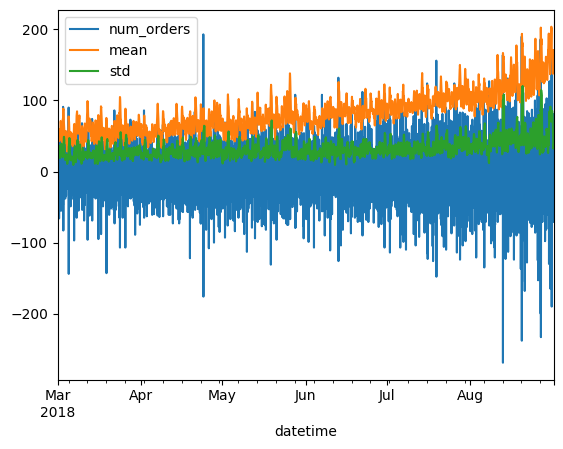

In [46]:
data_shifted=data.copy()

data_shifted-=data_shifted.shift()
data_shifted.drop(['rolling_mean'],axis=1,inplace=True)
data_shifted['mean'] = data_analysis['num_orders'].rolling(12).mean()
data_shifted['std'] = data_analysis['num_orders'].rolling(12).std()
data_shifted.plot()

## Entrenamiento

In [47]:
#Funcion para agregar características
def make_features(data,max_lag,rolling_mean_size):
  data['year']=data.index.year
  data['month']=data.index.month
  data['day']=data.index.day
  data['hour']=data.index.hour

  for lag in range(1,max_lag+1):
    data[f'lag_{lag}']=data['num_orders'].shift(lag)
  data['rolling_mean']=data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [48]:
make_features(data_model,4,12)

In [49]:
data_model.head(5)

,num_orders,year,month,day,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,66.0,71.0,85.0,124.0,NaN


## Separamos el dataset

In [50]:
seed=12345
train,test=train_test_split(data_model,
                            test_size=0.10,shuffle=False,random_state=seed)
train.dropna(inplace=True)
features_train=train.drop(['num_orders'],axis=1)
features_test=test.drop(['num_orders'],axis=1)
target_train=train['num_orders']
target_test=test['num_orders']


## Regresión Lineal

In [51]:
model_1=LinearRegression()
model_1.fit(features_train,target_train)
pred_1=model_1.predict(features_test)
rmse_1=mean_squared_error(target_test,pred_1)**0.5
print('RMSE:',rmse_1)

RMSE: 52.636608586271166


## CatBoost

In [52]:
grid = {'iterations': [50],
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [53]:
model_2=CatBoostRegressor(loss_function='RMSE',random_seed=seed)
grid_search_cat=model_2.grid_search(grid, X=features_train,y=target_train, shuffle=False,verbose=3)
best_params=grid_search_cat['params']
print(best_params)

0:	learn: 77.0792900	test: 112.1458202	best: 112.1458202 (0)	total: 2.27ms	remaining: 111ms
1:	learn: 75.1842979	test: 109.9632572	best: 109.9632572 (1)	total: 3.84ms	remaining: 92.2ms
2:	learn: 73.2915404	test: 107.6256615	best: 107.6256615 (2)	total: 5.41ms	remaining: 84.7ms
3:	learn: 71.4723982	test: 105.4139746	best: 105.4139746 (3)	total: 6.81ms	remaining: 78.4ms
4:	learn: 69.7041829	test: 103.2702460	best: 103.2702460 (4)	total: 8.16ms	remaining: 73.4ms
5:	learn: 67.9920822	test: 101.4731295	best: 101.4731295 (5)	total: 9.6ms	remaining: 70.4ms
6:	learn: 66.4185490	test: 99.7339042	best: 99.7339042 (6)	total: 10.6ms	remaining: 65ms
7:	learn: 64.8697406	test: 97.7652245	best: 97.7652245 (7)	total: 12.2ms	remaining: 64.2ms
8:	learn: 63.3470914	test: 95.8297316	best: 95.8297316 (8)	total: 13.6ms	remaining: 62.2ms
9:	learn: 61.8406629	test: 94.0681920	best: 94.0681920 (9)	total: 15ms	remaining: 60ms
10:	learn: 60.4032389	test: 92.1644081	best: 92.1644081 (10)	total: 16.5ms	remaining: 

In [54]:
#Evaluamos el modelo

best_model_1 = CatBoostRegressor(**best_params)
best_model_1.fit(features_train, target_train)
pred_2 = best_model_1.predict(features_test)
rmse_2 = mean_squared_error(target_test, pred_2)**0.5
print('RMSE: ', rmse_2)

0:	learn: 36.7660925	total: 2.72ms	remaining: 133ms


1:	learn: 35.0854686	total: 5.42ms	remaining: 130ms
2:	learn: 33.6994248	total: 7.75ms	remaining: 121ms
3:	learn: 32.5195273	total: 10ms	remaining: 116ms
4:	learn: 31.4533217	total: 12.5ms	remaining: 113ms
5:	learn: 30.5113691	total: 14.7ms	remaining: 108ms
6:	learn: 29.5989709	total: 17.1ms	remaining: 105ms
7:	learn: 29.0292544	total: 19.5ms	remaining: 103ms
8:	learn: 28.4648180	total: 22ms	remaining: 100ms
9:	learn: 28.0392488	total: 25.2ms	remaining: 101ms
10:	learn: 27.5214388	total: 27.6ms	remaining: 97.9ms
11:	learn: 26.9854869	total: 30.1ms	remaining: 95.3ms
12:	learn: 26.7141236	total: 32.4ms	remaining: 92.1ms
13:	learn: 26.3813439	total: 34.8ms	remaining: 89.4ms
14:	learn: 25.9489394	total: 37.7ms	remaining: 88ms
15:	learn: 25.6590197	total: 40.4ms	remaining: 85.9ms
16:	learn: 25.4320606	total: 42.6ms	remaining: 82.8ms
17:	learn: 25.1799659	total: 45.1ms	remaining: 80.1ms
18:	learn: 24.9773805	total: 47.4ms	remaining: 77.3ms
19:	learn: 24.7889375	total: 49.6ms	remaining: 74.4m

In [55]:
joblib.dump(best_model_1,'models/best_model_1.joblib')

['models/best_model_1.joblib']

## Light_gbm

In [56]:
#Entrenamos el modelo
model_lg =LGBMRegressor(random_state=seed,force_col_wise=True)


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 30, 50]
}
grid_2 = GridSearchCV(model_lg, param_grid, cv=3, scoring='r2')

grid_2.fit(features_train, target_train)

print("Mejores parametros:", grid_2.best_params_)
print("Mejores parametros: {:.2f}".format(grid_2.best_score_))
#Evaluamos el modelo
best_model = grid_2.best_estimator_
pred_3 = best_model.predict(features_test)
rmse_3 = mean_squared_error(target_test, pred_3)**0.5
print("RMSE:",rmse_3)

[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 87.904203
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 79.502461
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 2642, number of used features: 8
[LightGBM] [Info] Start training from score 67.661998
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 87.904203
[LightGBM] [Info] Total Bins 1053
[LightGBM] [Info] Number of data points in the train set: 2641, number of used features: 8
[LightGBM] [Info] Start training from score 79.502461
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 2642, number of

In [57]:
joblib.dump(grid_2,'models/grid_2.joblib')

['models/grid_2.joblib']

## XGBoost

In [58]:
#Entrenamos los datos
dtrain=xgb.DMatrix(features_train,label=target_train)
dtest=xgb.DMatrix(features_test,label=target_test)
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10
model_4 = xgb.train(param, dtrain, num_round, evallist)

#Evaluamos el modelo
pred_4 = model_4.predict(dtest)
xg_rmse=mean_squared_error(target_test,pred_4)**0.5
print("RMSE:",xg_rmse)


[0]	train-rmse:31.64120	eval-rmse:72.75792
[1]	train-rmse:29.12945	eval-rmse:60.27824
[2]	train-rmse:28.07192	eval-rmse:61.11633
[3]	train-rmse:27.05052	eval-rmse:58.79414
[4]	train-rmse:26.46230	eval-rmse:56.98930
[5]	train-rmse:25.65103	eval-rmse:54.65912
[6]	train-rmse:24.77185	eval-rmse:53.39041
[7]	train-rmse:24.52440	eval-rmse:51.79184
[8]	train-rmse:24.16587	eval-rmse:52.78145
[9]	train-rmse:23.93980	eval-rmse:50.73238
RMSE: 50.732375918841456


c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [59]:
joblib.dump(model_2,'models/model_2.joblib')

['models/model_2.joblib']

## RandomForest y DesicionTree

In [60]:
# Comenzamos por los modelos sin potenciación del gradiente
pipe_rf=Pipeline([('rf',RandomForestRegressor())])
pipe_dt=Pipeline([('dt',DecisionTreeRegressor())])

params=[{'rf__max_depth':[3,4,2,1],
         'rf__min_samples_split':[5,10,11,12],
         'rf__n_estimators':[10,20,30,40],
         'rf__min_samples_leaf':[1, 2, 4],
         'rf__bootstrap':[True, False],
         'rf__max_features':[np.random.randint(1, 11)]},
         {'dt__max_depth': [3,4,2,1],
         'dt__max_features':[np.random.randint(1, 9)],
         'dt__min_samples_leaf': [1, 2, 4]},
         ]

In [61]:
#Entrenamos nuestros modelos

pipes=[pipe_rf,pipe_dt]
for pipe,grid in zip(pipes,params):
    rs=RandomizedSearchCV(estimator=pipe,param_distributions=grid,scoring='r2',cv=2,random_state=seed)
    rs.fit(features_train,target_train)
    print(rs.best_params_)
    print(rs.best_score_)
    print(rs.best_estimator_)
    random_prediction = rs.best_estimator_.predict(features_test)
    joblib.dump(rs.best_estimator_,f'models/model_{pipe}.joblib')
    random_rmse=mean_squared_error(target_test,random_prediction)**0.5
    print("RMSE:",random_rmse)

{'rf__n_estimators': 10, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_features': 7, 'rf__max_depth': 4, 'rf__bootstrap': False}
0.14303929471202226
Pipeline(steps=[('rf',
                 RandomForestRegressor(bootstrap=False, max_depth=4,
                                       max_features=7, min_samples_split=10,
                                       n_estimators=10))])
RMSE: 58.55309158398739
{'dt__min_samples_leaf': 1, 'dt__max_features': 7, 'dt__max_depth': 4}
0.13162813826951186
Pipeline(steps=[('dt', DecisionTreeRegressor(max_depth=4, max_features=7))])
RMSE: 63.018910616668705


## Conclusiones

1. La tendencia de los datos es hacia el més de agosto, va creciendo la demanda de serviciós hacia el final del año

2. La serie es estacional, debido a que su distribución se repite diariamente con el siguiente comportamiento, picos de demanda a las horas: 0, 10, 15 y 24.

3. Al desarrollar los modelos de predicción de la serie temporal, los modelos que mejor error tuvieron fue el Light_gbm, el CatBoost y el XGBoost, con errores de 43.90, 47.06 y 50.73 respectivamente. Se debe tener en cuenta que al tener solo el 10% de los datos para prueba, es más complejo obtener un error menor.

4. Los modelos que pasaron la prueba de obtener un error inferior a 48 fueron el Light_gbm y el CatBoost. Los demás modelos tuvieron errores superiores, los cuales son: XGBoost, LinearRegression, RandomForestRegressor y DesicionTreeRegressor.